In [1]:
%matplotlib inline

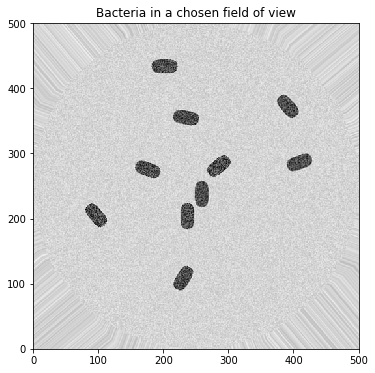

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import imshow,gray,show, title
from math import *
from scipy.ndimage import rotate


#Function Cell_frame() is used for generating cells in each frames
#Number of cells, size of cells and region of the interest (ROI) are able to be assignd to the function
#The default input values are: 1 cells with width of 20(pixels) and ROI of 400*400 dimension(pixels)
#This funtion return a density plot which shows the location of the cells in the ROI
def Cell_frame(Cell_number=1,Cell_width=20,ROI=[400,400]):
    
    #Translate the inputs to integers and initialize parameters for generating a density plot  
    Cell_number = int(Cell_number)
    Cell_width = int(Cell_width)    #in pixels
    size = np.random.randint(int(1.05*Cell_width),int(1.05*Cell_width)+1,Cell_number)  #allow 5% deviation in the cell width
    side_x = ROI[0]
    side_y = ROI[1]
    

    #empty array according to the dimension of ROI 
    a = np.empty((side_x+1,side_y+1))
   
    #Assign a inital values of each point in the density plot to simulated the background of the image
    #In phase-contrast bright-field images, the backgroud is much brighter than the cella=s
    #The intensity of each pixels is in range (0,2^8)
    for i in range(side_x+1):
        for j in range(side_y+1):
            a[i][j] = np.random.randint(245,257)   #the intensity is a random integer in range (245, 256) 
    
    
    #Pick random location(s) to introduce the cell(s) the density plot
    location_x = np.random.randint(0+2*Cell_width,side_x-2*Cell_width,Cell_number)
    location_y = np.random.randint(0+2*Cell_width,side_y-2*Cell_width,Cell_number)
    
    #Since only the centre of the cells are assigned, loop is used to generate a region around the centre with a rod-like shape 
    for i in range(Cell_number):
        half = int(size[i]/2)
        x = location_x[i]
        y = location_y[i]
        for n in range(half+1):
            f = int(half+1+sqrt(half**2-n**2))
            for p in range(f):
                a[x+p][y+n]  = np.random.randint(200,231)     #the intensity of cells is lower than the background
                a[x+p][y-n]  = np.random.randint(200,231)
                a[x-p][y+n]  = np.random.randint(200,231)
                a[x-p][y-n]  = np.random.randint(200,231)
        
        #A random rotation of each cells is generated as well
        angle = 10* np.random.randint(0,18)
        rot = rotate(a, angle, axes=(1, 0),reshape=False, mode='nearest')
        a = rot

    return a

Original = Cell_frame(Cell_number=10,Cell_width=20,ROI=[500,500])
fig, ax = plt.subplots(figsize=(6,6))
ax.set(xlim=(0, 501), ylim=(0, 501), title='Bacteria in a chosen field of view')
imshow(Original,cmap = 'gray')
show()
Original = Cell_frame(Cell_number=10,Cell_width=20,ROI=[500,500])

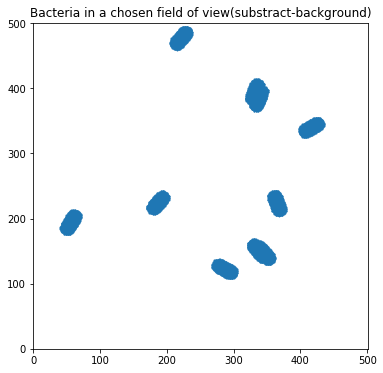

In [60]:
#This Filter() funtion mimic the image process procedure after take images with microscopy
#The basic idea is to substract backgroud since there is a big difference in the intensity between the background and cells 
#This function takes two input: x, is the density plot generated by the previous function Cell_frame
#                               ROI can be cropped or kept the same according the images
#Two outputs are: filtered, which gives the arrat which store infomation of image whose background has been substracted
#                 position, which gives the location of the cells 
#This function will show the position plot which indicates the location of the cells 
def Filter(x,ROI=[400,400]):
    side_x = ROI[0]
    side_y = ROI[1]
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set(xlim=(0, side_x+1), ylim=(0, side_y+1), title="Bacteria in a chosen field of view(substract-background)")

    #To get rid of the background and noise, a intensity threshold(241) is chosen 
    #Hence, for the pixels have intensity larger than 241, the intensity will be treated as the maximum value(256)
    #The pixels have intensity smaller than 241, will be treated as the minimum value(0)
    #Then the position of the pixels which has intensity less than 241
    filtered = np.select([x>241],[250])
    position = np.where(filtered < 241)
    position = np.array(position)
    plt.scatter(position[1],position[0],s = 1)
    show()
    
    return filtered,position

processed = Filter(Original,ROI = [500,500])

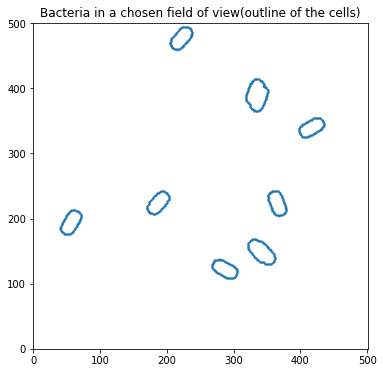

In [56]:
#After the image process, the outline of each cell can be found with function Outline()
#This step can be skip for low number of cells
def Outline(x,ROI=[400,400]):
    side_x = ROI[0]
    side_y = ROI[1]
    
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set(xlim=(0, side_x+1), ylim=(0, side_y+1), title='Bacteria in a chosen field of view(outline of the cells)')
    f = np.array(x[0])
    g = f.copy()
    for i in range(1, side_x):
        for j in range(1,side_y):
            if f[i][j] == f[i][j+1] and f[i][j] == f[i][j-1] and f[i][j] == f[i+1][j] and f[i][j] == f[i-1][j]:
                g[i][j] = 250 
                
    c = np.where(g < 241)
    c = np.array(c)
    plt.scatter(c[1],c[0], s=1)
    plt.show()
    return c

outline = Outline(processed, ROI=[500,500])

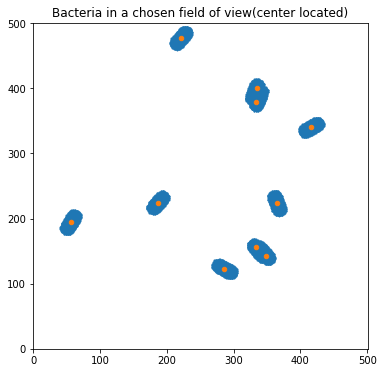

In [57]:
#The following steps are use to analysis the data that had been generated previously 
#First, find out the centre of the cells and its location using KMeans function in sklearn.cluster
#Source: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
from sklearn.cluster import KMeans 

fig, ax = plt.subplots(figsize=(6,6))
ax.set(xlim=(0, 501), ylim=(0, 501), title='Bacteria in a chosen field of view(center located)')
    
points  = np.array(processed[1])
Points = points.transpose()
kmeans = KMeans(n_clusters=10, random_state=0).fit(Points)
c = np.array(kmeans.cluster_centers_)
belongs = kmeans.fit_predict(Points)
centers = c.transpose()

plt.scatter(processed[1][1],processed[1][0], s= 1)
plt.scatter(centers[1],centers[0], s=20)
show()

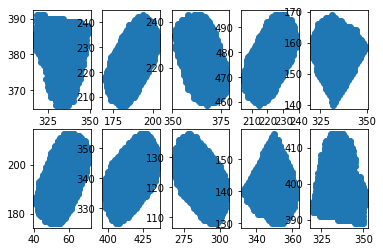

In [58]:
#this step is to segment the cells and plot each cells separately
#And the cell length and width of each cells are obtaied
from sklearn.decomposition import PCA 

x= processed[1][1]
y= processed[1][0]
width = []
length = []

#Loop for separating cells and plot them in separate graphs
for i in range(0,10):
    segmentation_x = []
    segmentation_y = []
    s = np.where(belongs == i)
    s = np.array(s[0])
    
    #Get the posiitons of points in each cell
    for j in range(len(s)):         
        segmentation_x.append(x[int(s[j])])
        segmentation_y.append(y[int(s[j])])
    
    plt.subplot(2,5,i+1)
    plt.scatter(segmentation_x,segmentation_y)
    
    d = np.array(list(zip(segmentation_x,segmentation_y)))
    
    #Using PCA funtion to transform each cell that makes sure the principle axis is aligning with x-axis
    #Therefore, the size of the cells can be easily calculated from maxima-minima along the principle axis
    skl_PCA = PCA(n_components = 2).fit(d)
    skl_d_transformed = skl_PCA.transform(d)
    #plt.scatter(skl_d_transformed[:,0], skl_d_transformed[:,1])
    top = np.max(skl_d_transformed[:,1])
    bottom = np.min(skl_d_transformed[:,1])
    right = np.max(skl_d_transformed[:,0])
    left = np.min(skl_d_transformed[:,0])    
    width.append(top-bottom)
    length.append(right - left)

In [59]:
average_width = np.mean(width)
average_length = np.mean(length)
print ("The average width of these cells is:", average_width/20,"um")
print ("The average length of these cells is:", average_length/20,"um")
for i in range(10):
    print ("The width of cell#", i+1, "is",width[i]/20,"um")
    print ("The length of cell#", i+1, "is",length[i]/20,"um")

The average width of these cells is: 1.198917889454831 um
The average length of these cells is: 1.803082699907483 um
The width of cell# 1 is 1.3361243507851701 um
The length of cell# 1 is 1.5052416026046616 um
The width of cell# 2 is 1.074574732064903 um
The length of cell# 2 is 2.0229910718704116 um
The width of cell# 3 is 1.082605007552908 um
The length of cell# 3 is 2.024764785375091 um
The width of cell# 4 is 1.0820608761059944 um
The length of cell# 4 is 2.054980243519142 um
The width of cell# 5 is 1.4479302876938616 um
The length of cell# 5 is 1.4052282212638434 um
The width of cell# 6 is 1.0777088093089362 um
The length of cell# 6 is 2.015546574326037 um
The width of cell# 7 is 1.0791233282930464 um
The length of cell# 7 is 2.0155643554401896 um
The width of cell# 8 is 1.0803626341621508 um
The length of cell# 8 is 2.015549427913541 um
The width of cell# 9 is 1.39967602726119 um
The length of cell# 9 is 1.4533914233859306 um
The width of cell# 10 is 1.329012841320149 um
The leng